<a href="https://colab.research.google.com/github/Myashka/IVICT.HACK-team-HI/blob/baseline/Train_with_torch_new_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install -q transformers

     |████████████████████████████████| 4.2 MB 35.7 MB/s 
     |████████████████████████████████| 596 kB 64.1 MB/s 
     |████████████████████████████████| 6.6 MB 51.6 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 


In [3]:
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
import torchsummary

In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [5]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import time
from collections import defaultdict
from tqdm.auto import tqdm

import warnings
warnings.simplefilter("ignore")
import os

In [6]:
!wget --no-check-certificate https://raw.githubusercontent.com/Myashka/IVICT.HACK-team-HI/data/dataset.csv

--2022-05-22 08:09:05--  https://raw.githubusercontent.com/Myashka/IVICT.HACK-team-HI/data/dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8106782 (7.7M) [text/plain]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>]   7.73M  --.-KB/s    in 0.03s   

2022-05-22 08:09:06 (242 MB/s) - ‘dataset.csv’ saved [8106782/8106782]



In [7]:
dataset = pd.read_csv('dataset.csv', usecols=[1,2])
dataset.head(5)

,text,label
0,@tiffanylue i know i was listenin to bad habi...,empty
1,Layin n bed with a headache ughhhh...waitin o...,sadness
2,Funeral ceremony...gloomy friday...,sadness
3,wants to hang out with friends SOON!,enthusiasm
4,@dannycastillo We want to trade with someone w...,neutral


In [18]:
class_weights = (1 - (dataset['label'].value_counts().sort_index() / len(dataset))).values
class_weights = torch.from_numpy(class_weights).float().to(device)

In [19]:
encode_dict = {}

def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

dataset['encoded_label'] = dataset['label'].apply(lambda x: encode_cat(x))

In [20]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 4
EPOCHS = 3
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [21]:
class Emotion_dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        text = str(self.data.text[index])
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.encoded_label[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [22]:
train_size = 0.8
train_dataset = dataset.sample(frac=train_size)
test_dataset = dataset.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(dataset.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Emotion_dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = Emotion_dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (81459, 3)
TRAIN Dataset: (65167, 3)
TEST Dataset: (16292, 3)


In [23]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [36]:
class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-cased")
        self.pre_classifier = torch.nn.Linear(768, 512)
        self.lin1 = torch.nn.Linear(512, 258)
        self.lin2 = torch.nn.Linear(258, 128)
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.dropout = torch.nn.Dropout(0.2)
        self.classifier = torch.nn.Linear(128, len(encode_dict))

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.bn1(pooler)
        pooler = self.dropout(pooler)
        pooler = self.lin1(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.lin2(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.bn2(pooler)
        output = self.classifier(pooler)
        return output

In [32]:
# torchsummary.summary(DistillBERTClass().to(device), [(512, 2), (512, 2) ], dtypes=[torch.long, torch.long])

In [26]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [27]:
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

In [37]:
model = DistillBERTClass().to(device)
optim = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
loss_func = CrossEntropyLoss(weight=class_weights)

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs=EPOCHS):
    train_loss = []
    val_loss = []
    val_accuracy = []

    best_valid_loss = float('inf')
    
    for epoch in tqdm(range(n_epochs)):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()
        
        model.train(True)
        for step, data in tqdm(enumerate(train_loader)):
            opt.zero_grad()
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            
            outputs = model(ids, mask)            
            
            loss = loss_fn(outputs, targets)
            loss.backward()
            opt.step()
            
            ep_train_loss.append(loss.item())

            if (step+1)%100==0:
              clear_output(True)
              plt.plot(ep_train_loss,label='Epoch loss')
              plt.legend()
              plt.show()

            if step % 100 == 0:
              print(f'Batch {step} of {len(train_loader) }')
              print(f'Train loss: {np.mean(ep_train_loss)}')
            
        model.train(False)
        with torch.no_grad():
            for step, data in tqdm(enumerate(val_loader)):
                
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.long)
                
                outputs = model(ids, mask)
                
                loss = loss_fn(outputs, targets)
                
                ep_val_loss.append(loss.item())
                y_pred = outputs.max(1)[1].data
                ep_val_accuracy.append(accuracy_score(targets.cpu().numpy(), y_pred.cpu().numpy()))
                
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')
        

        if np.mean(ep_val_loss) < best_valid_loss:
          best_valid_loss = np.mean(ep_val_loss)

          save_checkpoint('best_model.pth', model, optim)

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

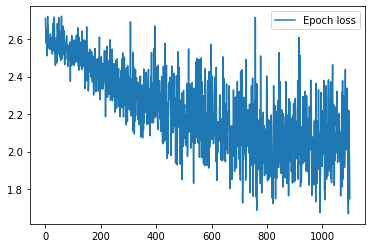

Batch 1100 of 4073
Train loss: nan


KeyboardInterrupt: ignored

In [35]:
train_loss, val_loss, val_accuracy = train_model(model, training_loader, testing_loader, loss_func, optim)

In [ ]:
train_loss, val_loss, val_accuracy

([1.7871566437332982, 1.2408810728324475, 1.1318103463563673],
 [1.305938241729847, 1.184774124807832, 1.1538579129775597],
 [0.5149152958507243, 0.5547507979376382, 0.5584335870365824])

In [ ]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    print(f'Max accurasy score: {max(val_accuracy)} at {np.argmax(val_accuracy)} epoch')
    
    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)
    axes[1].plot(np.argmax(val_accuracy), max(val_accuracy), 'ro')

Max accurasy score: 0.5584335870365824 at 2 epoch


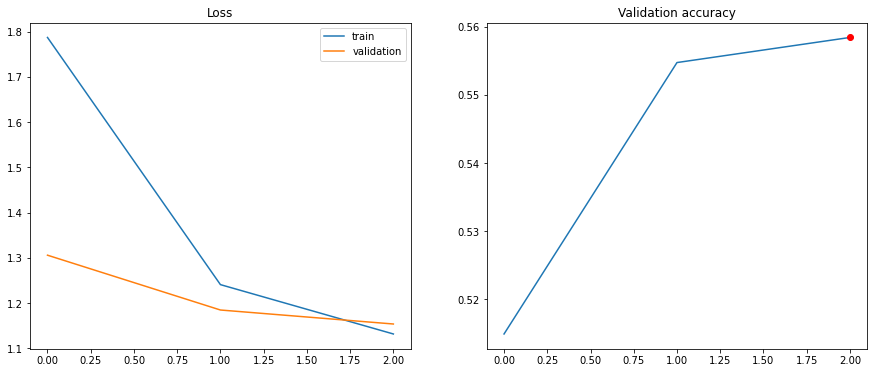

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [ ]:
load_checkpoint('best_model.pth', model, optim)

model loaded from best_model.pth


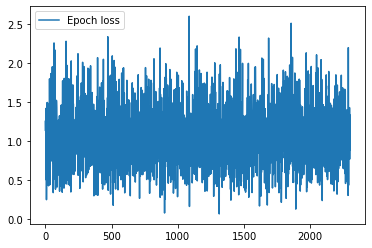

KeyboardInterrupt: ignored

In [ ]:
train_loss_2, val_loss_2, val_accuracy_2 = train_model(model, training_loader, testing_loader, loss_func, optim)

Обобщающей способности не хватает, попробуем усложнить модель